In [1]:
import joblib
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder, RareLabelCategoricalEncoder, MeanCategoricalEncoder

from sklearn.ensemble import GradientBoostingRegressor
from catboost.core import CatBoostRegressor

%matplotlib inline

In [2]:
pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [3]:
data = pd.read_csv('house_prices_advanced_regression_techniques/train.csv')
train = data.copy(deep=True)
nanval_cols = ['Alley', 'BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'MiscFeature', 'FireplaceQu', 'PoolQC']
for i in nanval_cols:
    train[i].replace(np.NaN, 'No', regex=True, inplace=True)
print(train.shape)
train.head()

(1460, 81)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave    No      Reg   
1   2          20       RL         80.0     9600   Pave    No      Reg   
2   3          60       RL         68.0    11250   Pave    No      IR1   
3   4          70       RL         60.0     9550   Pave    No      IR1   
4   5          60       RL         84.0    14260   Pave    No      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0          No   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [4]:
profile = ProfileReport(train, check_correlation=True)
profile

/home/nm/miniconda3/envs/temp/lib/python3.7/site-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [4]:
# sum all the areas into TotBuiltUpArea
train['TotBuiltUpArea'] = train.TotalBsmtSF.add(train['1stFlrSF']).add(train['2ndFlrSF']).add(train['GrLivArea']).add(train['GarageArea']).add(train.TotalBsmtSF)
train.drop(labels=['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'TotalBsmtSF'], axis=1, inplace=True)

In [5]:
# sum all the rooms into TotRoomsAbvGrd
train['TotRmsAbvGrd'] = train[['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath']].sum(axis=1).add(train['TotRmsAbvGrd'])
train.drop(labels=['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'], axis=1, inplace=True)

In [6]:
# Combining all porches SF into a single column and creating porches type indicator
porches = ['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']

## summing all the porch SF into a single column
train['PorchSF'] = train.iloc[:,66:71].sum(axis=1)

## Creating porch class label
for i in range(len(porches)):
    train.loc[train[porches[i]] > 0, porches[i]] = i+1

train['PorchType'] = train[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].sum(axis=1)

## Deleting redundant labels
train.drop(labels=porches, axis=1, inplace=True)

In [7]:
# remove columns
remove_cols = ['Id', 'Street', 'Utilities', 'Condition2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BedroomAbvGr','KitchenAbvGr', 'KitchenQual', 'PoolArea', 'PoolQC']
train.drop(labels=remove_cols, axis=1, inplace=True)

In [8]:
train['TransactionAge'] = dt.date.today().year - train['YrSold']
train['TransactionAge'] = 1/train['TransactionAge']

In [9]:
train['AgeAtSale'] = train['YrSold'].sub(train['YearBuilt'])

train['RemodAgeAtSale'] = train['YrSold'].sub(train['YearRemodAdd'])

# NaN values to have artibarily large numbers
train['GarageAgeAtSale'] = train['YrSold'].sub(train['GarageYrBlt'].fillna(0))

train.drop(labels=['MoSold', 'YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

In [10]:
# missing value imputation
## Find out Missing Values.
missing_values = train.columns[train.isnull().any()].tolist()
print('Missing values: ', missing_values)

## First we'll fill in the sole missing value of 'Electricals' column with most frequent missing label.
train['Electrical'].fillna(value=train['Electrical'].mode()[0], inplace=True)

# Replacing 'MasVnrArea' with mean value, and 
train['MasVnrArea'].fillna(value=train.MasVnrArea.mean(), inplace=True)

train['MasVnrType'].fillna(value='missing', inplace=True)

missing_values = train.columns[train.isnull().any()].tolist()
print('Missing values: ', missing_values)

Missing values:  ['LotFrontage', 'MasVnrType', 'MasVnrArea', 'Electrical']
Missing values:  ['LotFrontage']


In [11]:
# Load Preprocessed dataset with subset of variables from the dataset 
imputed_values = joblib.load('imputed_values.pkl')

# Replacing missing values of LotFrontage.
train.loc[train['LotFrontage'].isnull(),'LotFrontage'] = imputed_values

In [12]:
# Log transformation variables
log_cols = ['LotFrontage', 'LotArea']
for i in log_cols:
    train[i] = np.log(train[i])

In [13]:
if len(train.columns[train.isnull().any()].tolist())>0:
    print('Missing Values: ', train.columns[train.isnull().any()].tolist())
else:
    print('No NaN values found!')
print('='*15)

No NaN values found!


In [14]:
profile = ProfileReport(train, check_correlation=True, )
profile

/home/nm/miniconda3/envs/temp/lib/python3.7/site-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [15]:
X = train.drop(labels=['SalePrice'], axis=1)
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

col_names = train.columns.tolist()
col_names.remove('SalePrice')

In [16]:
continuous = ['LotFrontage', 'LotArea', 'MasVnrArea', 'Fireplaces', 'GarageCars', 'MiscVal', 'TotBuiltUpArea', 'PorchSF', 'AgeAtSale']
nom_int = ['MSSubClass', 'PorchType', 'TransactionAge']
nom_obj = ['MSZoning', 'Alley', 'LandContour', 'LotShape','LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl','Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition']
ord_int = ['OverallQual', 'OverallCond']
ord_obj = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond','BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence']

In [17]:
pipe = Pipeline([
    ('rareLabels', RareLabelCategoricalEncoder(n_categories=5, variables=nom_obj)),
    ('ordinal_encode', OrdinalCategoricalEncoder(variables=ord_obj))
])
pipe.fit(X_train, y_train)

/home/nm/miniconda3/envs/temp/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable MSZoning is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))
/home/nm/miniconda3/envs/temp/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable Alley is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))
/home/nm/miniconda3/envs/temp/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable LandContour is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be consi

Pipeline(steps=[('rareLabels',
                 RareLabelCategoricalEncoder(n_categories=5,
                                             variables=['MSZoning', 'Alley',
                                                        'LandContour',
                                                        'LotShape', 'LotConfig',
                                                        'LandSlope',
                                                        'Neighborhood',
                                                        'Condition1',
                                                        'BldgType',
                                                        'HouseStyle',
                                                        'RoofStyle', 'RoofMatl',
                                                        'Exterior1st',
                                                        'Exterior2nd',
                                                        'MasVnrType',
                                     

In [18]:
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

In [19]:
params = {'iterations':5000, 
          'learning_rate':0.001, 
          'depth':5,
          'loss_function':'RMSE', 
          'eval_metric':'RMSE', 
          'random_seed': 0, 
          'od_type':'Iter', 
          'metric_period':50, 
          'od_wait':20,
          'verbose': True, 
          'use_best_model': True, 
          'reg_lambda':0.1, 
          'cat_features':nom_obj}

model = CatBoostRegressor(**params)


model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 78414.1206934	test: 83054.3102018	best: 83054.3102018 (0)	total: 59.4ms	remaining: 4m 56s
50:	learn: 75778.6840758	test: 80463.6220646	best: 80463.6220646 (50)	total: 547ms	remaining: 53.1s
100:	learn: 73288.1405511	test: 78019.7173423	best: 78019.7173423 (100)	total: 1.01s	remaining: 49.1s
150:	learn: 70929.8668119	test: 75742.7664762	best: 75742.7664762 (150)	total: 1.45s	remaining: 46.6s
200:	learn: 68678.5526463	test: 73560.8995551	best: 73560.8995551 (200)	total: 1.87s	remaining: 44.7s
250:	learn: 66554.5657304	test: 71483.0990077	best: 71483.0990077 (250)	total: 2.29s	remaining: 43.3s
300:	learn: 64504.4123720	test: 69514.0036713	best: 69514.0036713 (300)	total: 2.74s	remaining: 42.8s
350:	learn: 62566.7868718	test: 67640.4835415	best: 67640.4835415 (350)	total: 3.17s	remaining: 42s
400:	learn: 60686.6540853	test: 65822.4732686	best: 65822.4732686 (400)	total: 3.61s	remaining: 41.4s
450:	learn: 58908.1300353	test: 64108.1398722	best: 64108.1398722 (450)	total: 4.04s	rem

4000:	learn: 21127.2804146	test: 32456.3420172	best: 32456.3420172 (4000)	total: 35.6s	remaining: 8.9s
4050:	learn: 21022.2884365	test: 32406.6650736	best: 32406.6650736 (4050)	total: 36.1s	remaining: 8.46s
4100:	learn: 20928.5980238	test: 32377.2286003	best: 32377.2286003 (4100)	total: 36.6s	remaining: 8.02s
4150:	learn: 20835.6350780	test: 32349.0068227	best: 32349.0068227 (4150)	total: 37s	remaining: 7.58s
4200:	learn: 20750.1574491	test: 32308.6445827	best: 32308.6445827 (4200)	total: 37.5s	remaining: 7.14s
4250:	learn: 20661.2014381	test: 32269.0715445	best: 32268.9282552 (4248)	total: 38s	remaining: 6.69s
4300:	learn: 20570.6793811	test: 32240.0317010	best: 32238.2542728 (4297)	total: 38.4s	remaining: 6.25s
4350:	learn: 20485.7474035	test: 32213.3561969	best: 32212.5020363 (4348)	total: 38.9s	remaining: 5.8s
4400:	learn: 20404.7339338	test: 32174.2295966	best: 32174.2295966 (4400)	total: 39.4s	remaining: 5.36s
4450:	learn: 20321.2756682	test: 32141.2876819	best: 32141.1151096 (44

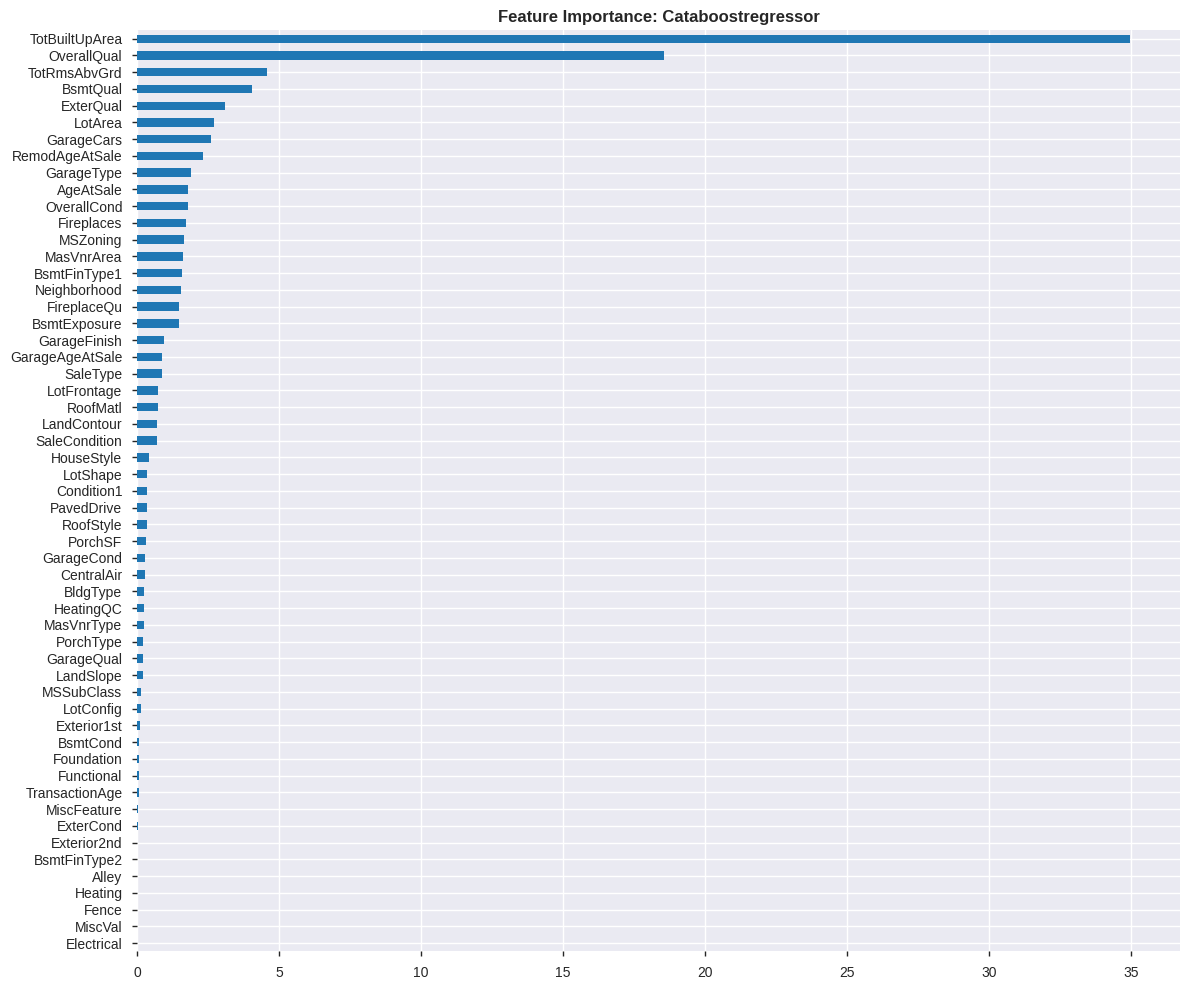

In [20]:
plt.figure(figsize=(12,10))
pd.Series(model.get_feature_importance(), index=col_names).sort_values().plot(kind='barh');
plt.title('Feature Importance: Cataboostregressor', fontweight='semibold')
plt.tight_layout()
plt.show()

#### Preventing Overfitting through Feature Selection

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [41]:
pipe = Pipeline([
    ('rareLabels', RareLabelCategoricalEncoder(n_categories=5, variables=nom_obj)),
    ('mean_encod', MeanCategoricalEncoder(variables=nom_obj)),
    ('ordinal_encode', OrdinalCategoricalEncoder(variables=ord_obj)),
    ('selector', RFE(estimator=GradientBoostingRegressor(random_state=0)))
])
pipe.fit(X_train, y_train)

/home/nm/miniconda3/envs/temp/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable MSZoning is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))
/home/nm/miniconda3/envs/temp/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable Alley is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))
/home/nm/miniconda3/envs/temp/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable LandContour is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be consi

Pipeline(steps=[('rareLabels',
                 RareLabelCategoricalEncoder(n_categories=5,
                                             variables=['MSZoning', 'Alley',
                                                        'LandContour',
                                                        'LotShape', 'LotConfig',
                                                        'LandSlope',
                                                        'Neighborhood',
                                                        'Condition1',
                                                        'BldgType',
                                                        'HouseStyle',
                                                        'RoofStyle', 'RoofMatl',
                                                        'Exterior1st',
                                                        'Exterior2nd',
                                                        'MasVnrType',
                                     

In [42]:
col_names_new = np.array(col_names)[pipe.named_steps.selector.support_]
X_train_new = pd.DataFrame(data=pipe.named_steps.selector.transform(X_train), columns=col_names_new)
X_test_new = pd.DataFrame(data=pipe.named_steps.selector.transform(X_test), columns=col_names_new)

In [43]:
cont_new = [i for i in continuous if i in col_names_new]
nom_int_new = [i for i in nom_int if i in col_names_new]
nom_obj_new = [i for i in nom_obj if i in col_names_new]
ord_int_new = [i for i in ord_int if i in col_names_new]
ord_obj_new = [i for i in ord_obj if i in col_names_new]

In [44]:
ord_encode = OrdinalCategoricalEncoder(variables=ord_obj_new)
X_train_new = ord_encode.fit_transform(X_train_new, y_train)
X_test_new = ord_encode.transform(X_test_new)

In [51]:
params = {'iterations':5000, 
          'learning_rate':0.001, 
          'depth':5,
          'loss_function':'RMSE', 
          'eval_metric':'RMSE', 
          'random_seed': 0, 
          'od_type':'Iter', 
          'metric_period':50, 
          'od_wait':15,
          'verbose': True, 
          'use_best_model': True, 
          'reg_lambda':0.1,
          'cat_features': nom_obj_new}

model = CatBoostRegressor(**params)


model.fit(X_train_new, y_train, eval_set=(X_test_new, y_test), use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 78412.7699464	test: 83051.1523203	best: 83051.1523203 (0)	total: 4.93ms	remaining: 37s
50:	learn: 75783.5441901	test: 80462.7591686	best: 80462.7591686 (50)	total: 193ms	remaining: 28.1s
100:	learn: 73241.1210650	test: 77959.7132099	best: 77959.7132099 (100)	total: 378ms	remaining: 27.7s
150:	learn: 70858.1130671	test: 75611.2823329	best: 75611.2823329 (150)	total: 525ms	remaining: 25.6s
200:	learn: 68560.6429720	test: 73365.2741686	best: 73365.2741686 (200)	total: 691ms	remaining: 25.1s
250:	learn: 66362.2393074	test: 71214.1396374	best: 71214.1396374 (250)	total: 841ms	remaining: 24.3s
300:	learn: 64288.5899679	test: 69174.0342042	best: 69174.0342042 (300)	total: 1s	remaining: 24.1s
350:	learn: 62290.0463870	test: 67240.8869037	best: 67240.8869037 (350)	total: 1.16s	remaining: 23.6s
400:	learn: 60392.3333220	test: 65389.8445003	best: 65389.8445003 (400)	total: 1.33s	remaining: 23.6s
450:	learn: 58595.8874525	test: 63656.4902321	best: 63656.4902321 (450)	total: 1.48s	remaini

4050:	learn: 20439.1413501	test: 31079.2522410	best: 31079.2522410 (4050)	total: 14.4s	remaining: 12.3s
4100:	learn: 20344.9398653	test: 31034.9125371	best: 31034.9125371 (4100)	total: 14.6s	remaining: 12.1s
4150:	learn: 20252.5198956	test: 30996.9589238	best: 30996.9589238 (4150)	total: 14.8s	remaining: 11.9s
4200:	learn: 20161.6569095	test: 30955.5734634	best: 30955.5734634 (4200)	total: 14.9s	remaining: 11.7s
4250:	learn: 20074.1491161	test: 30924.7604245	best: 30924.7604245 (4250)	total: 15.1s	remaining: 11.5s
4300:	learn: 19989.9784315	test: 30888.3667241	best: 30888.3667241 (4300)	total: 15.3s	remaining: 11.4s
4350:	learn: 19907.9689306	test: 30858.7363677	best: 30858.7363677 (4350)	total: 15.4s	remaining: 11.2s
4400:	learn: 19829.2035007	test: 30815.0158980	best: 30815.0158980 (4400)	total: 15.6s	remaining: 11s
4450:	learn: 19746.9605374	test: 30784.7702253	best: 30784.7051994 (4448)	total: 15.8s	remaining: 10.8s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 

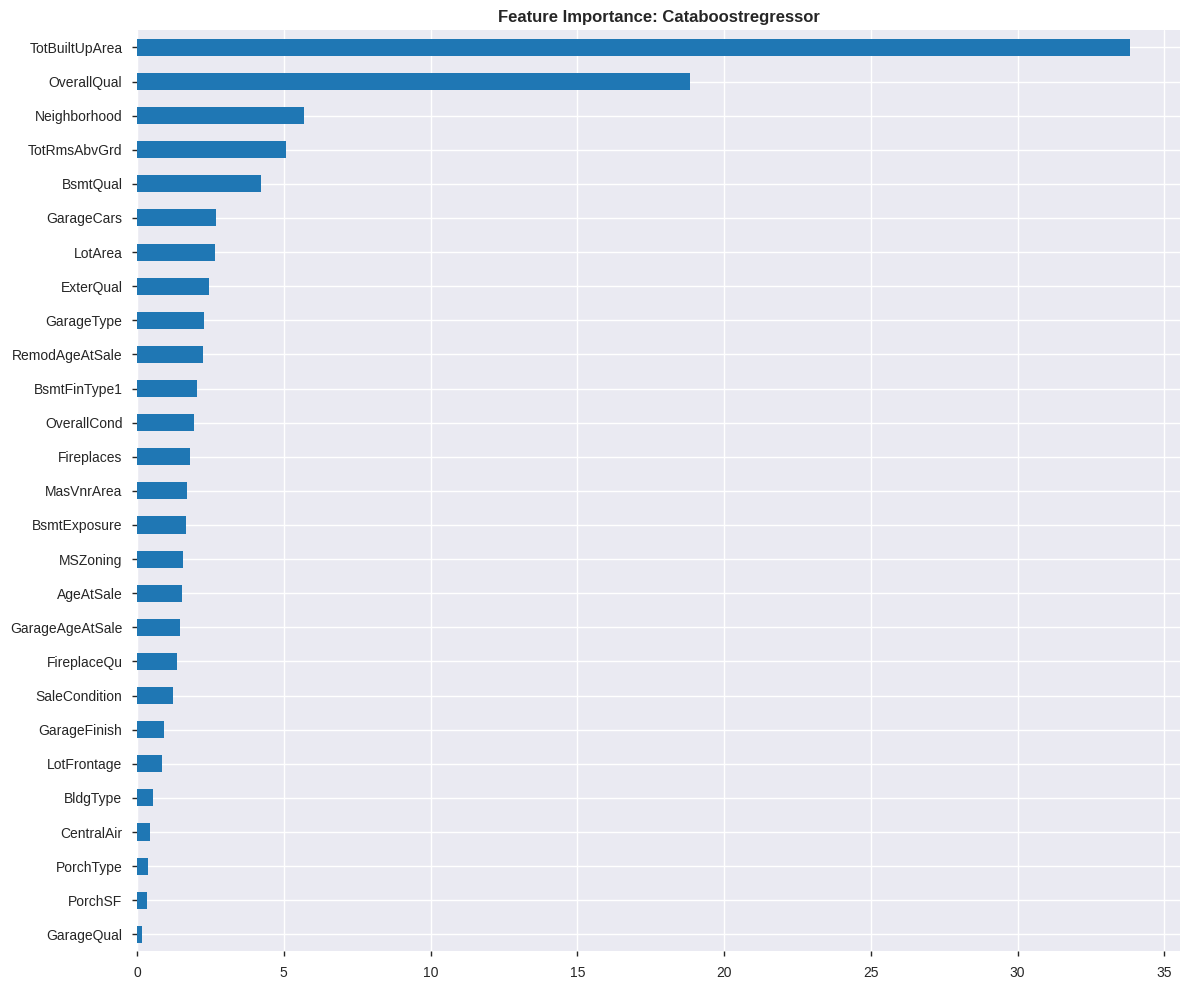

In [52]:
plt.figure(figsize=(12,10))
pd.Series(model.get_feature_importance(), index=col_names_new).sort_values().plot(kind='barh');
plt.title('Feature Importance: Cataboostregressor', fontweight='semibold')
plt.tight_layout()
plt.show()